# Adding Multiple Wells

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

**Authors**
- _R.A. Collenteur, Artesia Water 2018_
- _D.A. Brakenhoff, Artesia Water 2019_
- _R.C. Caljé, Artesia Water 2020_

Import the requisite modules

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.0.5
Pastas version: 0.15.0b


## Load data from a Menyanthes file
Menyanthes is timeseries analysis software used by many people in the Netherlands. In this example a Menyanthes-file with one observation-series is imported, and simulated. There are several stresses in the Menyanthes-file, among which are three groundwater extractions with a significant influence on groundwater head.

Import the Menyanthes-file with observations and stresses.

In [2]:
fname = '../data/MenyanthesTest.men'
meny = ps.read.MenyData(fname)

Get the distances of the extractions to the observation well. Extraction 1 is about two times as far from the observation well as extraction 2 and 3. We will use this information later in our WellModel.

In [3]:
# Get distances from metadata
xo = meny.H["Obsevation well"]['xcoord']
yo = meny.H["Obsevation well"]['ycoord']
distances = []
extraction_names = ['Extraction 1', 'Extraction 2', 'Extraction 3']
for extr in extraction_names:
    xw = meny.IN[extr]["xcoord"]
    yw = meny.IN[extr]["ycoord"]
    distances.append(np.sqrt((xo-xw)**2 + (yo-yw)**2))
extraction_names = [name.replace(" ", "_") for name in extraction_names]  # replace spaces in names for Pastas
df = pd.DataFrame(distances, index=extraction_names, columns=['Distance to Observation well'])
df

,Distance to Observation well
Extraction_1,5076.464352
Extraction_2,2281.964490
Extraction_3,2783.783397


Then plot the observations, together with the diferent stresses in the Menyanthes file.

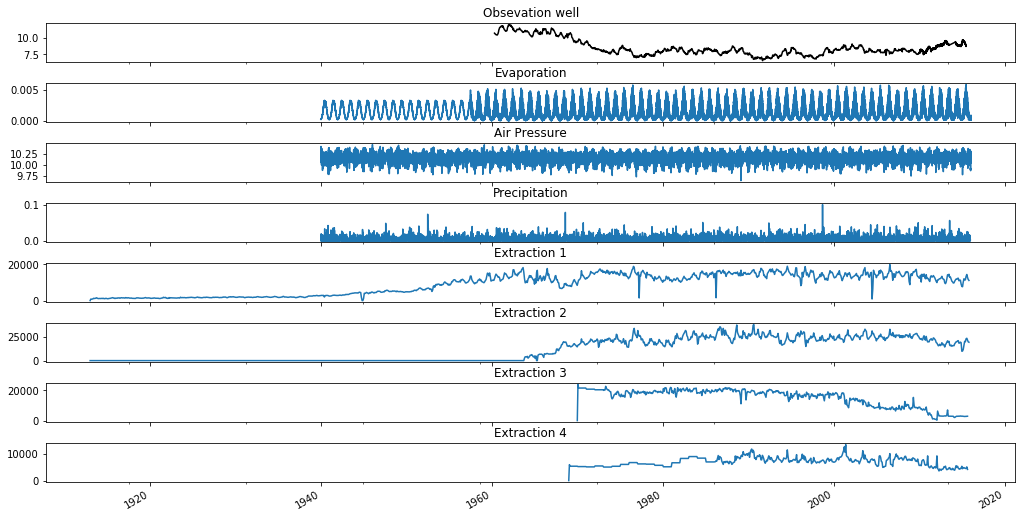

In [4]:
# plot some series
f1, axarr = plt.subplots(len(meny.IN)+1, sharex=True, figsize=(14,7))
oseries = meny.H['Obsevation well']["values"]
oseries.plot(ax=axarr[0], color='k')
axarr[0].set_title(meny.H['Obsevation well']["Name"])
for i, val in enumerate(meny.IN.items()):
    name, data = val
    data["values"].plot(ax=axarr[i+1])
    axarr[i+1].set_title(name)
plt.tight_layout(pad=0)

## Create a model with a separate StressModel for each extraction

First we create a model with a separate StressModel for each groundwater extraction. First we create a model with the heads timeseries and add recharge as a stress.

In [5]:
ml = ps.Model(ps.TimeSeries(meny.H['Obsevation well']['values'], name="heads"))

INFO: Cannot determine frequency of series heads


Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [6]:
IN = meny.IN['Precipitation']['values']
IN.index = IN.index.round("D")
IN.name = "prec"
IN2 = meny.IN['Evaporation']['values']
IN2.index = IN2.index.round("D")
IN2.name = "evap"

Create a recharge stressmodel and add to the model.

In [7]:
sm = ps.StressModel2([IN, IN2], ps.Gamma, 'Recharge')
ml.add_stressmodel(sm)

INFO: Inferred frequency from time series prec: freq=D 
INFO: Inferred frequency from time series evap: freq=D 


Get the extraction timeseries.

In [7]:
stresses = []
for name in extraction_names:
    stress = ps.TimeSeries(meny.IN[name.replace("_", " ")]['values'], name=name, settings='well')
    # the time unit is already days, so we need te set to_daily_unit to None
    stress.update_series(to_daily_unit=None)
    stresses.append(stress)    

INFO: Cannot determine frequency of series Extraction_1
INFO: Time Series Extraction_1: values of stress were transformed to daily values (frequency not altered) with: divide
INFO: Cannot determine frequency of series Extraction_2
INFO: Time Series Extraction_2: values of stress were transformed to daily values (frequency not altered) with: divide
INFO: Cannot determine frequency of series Extraction_3
INFO: Time Series Extraction_3: values of stress were transformed to daily values (frequency not altered) with: divide


Add each of the extractions as a separate StressModel.

In [8]:
for stress in stresses:
    sm = ps.StressModel(stress, ps.Hantush, stress.name, up=False)
    ml.add_stressmodel(sm)

INFO: Time Series Extraction_1 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_3 was sampled down to freq D with method timestep_weighted_resample


Solve the model. 

Note the use of `ps.LmfitSolve`. This is because of [an issue concerning optimization with small parameter values](https://github.com/pastas/pastas/issues/177) in `scipy.least_squares`. This is something that may influence models containing a WellModel (which we will be creating later) and since we want to keep the models in this Notebook as similar as possible, we're also using `ps.LmfitSolve` here.

In [9]:
ml.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_1 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_3 was sampled down to freq D with method timestep_weighted_resample
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                         Fit Statistics
nfev     592                    EVP                   0.00
nobs     2843                   R2                    1.00
noise    True                   RMSE                   nan
tmin     1960-04-28 00:00:00    AIC                    inf
tmax     2015-06-29 00:00:00    BIC                    nan
freq     D                      Obj                  24.69
warmup   3650 days 00:00:00     ___                       
solver   LmfitSolve             ___                       

Parameters (11 were optimized)
                    optimal       stderr     initial  vary
Extraction_1_A    -0.003629  ±173277.34%   -0.000178  True
Extraction_1_a  1654.492337   ±18771.52%  100.000000  True
Extraction_1_b    16.253657   ±39590.86%    1.000000  True
Extraction_2_A    -0.002731     ±328.98%   -0.000086  True
Extraction_2_a   525.873449     ±125.93%  100.000000  True
Extraction_2_b     2.220294     ±209.78%    1.000000  True
Extraction_3_A    -0.000

/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt((res ** 2).sum() / n)
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:313: RuntimeWarning: divide by zero encountered in log
  return -2.0 * log((res ** 2.0).sum()) + 2.0 * nparam
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:277: RuntimeWarning: divide by zero encountered in log
  return -2.0 * log((res ** 2.0).sum()) + nparam * log(res.size)
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return -2.0 * log((res ** 2.0).sum()) + nparam * log(res.size)


### Visualize the results
Plot the decomposition to see the individual influence of each of the wells.

In [17]:
ml.simulate().var() / ml.observations().var()

1.3032517593640418

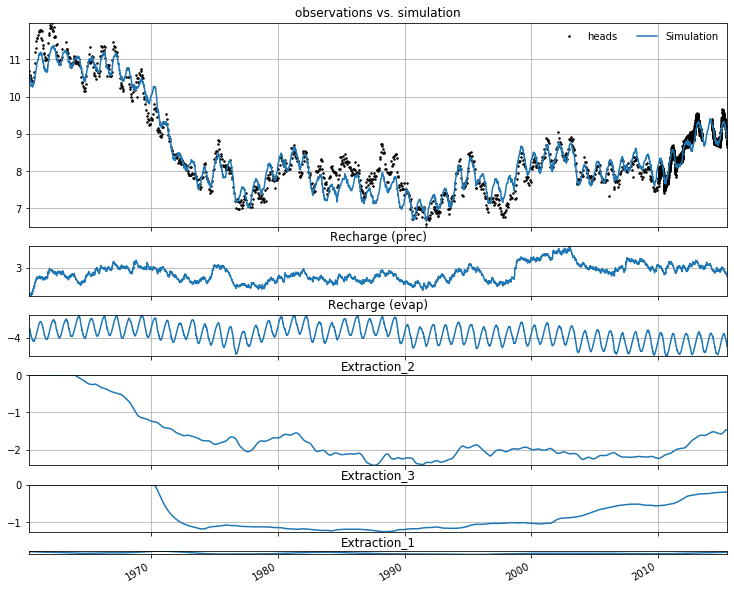

In [21]:
ml.plots.decomposition();

We can calculate the gain of each extraction (quantified as the effect on the groudnwater level of an extraction of ~1000 m3/d).

In [12]:
for i in range(3):
    name = extraction_names[i]
    sm = ml.stressmodels[name]
    p = ml.get_parameters(name)
    gain = sm.rfunc.gain(p) * 1e6 / 365.25
    print("{0}: gain = {1:.2f} m / million m^3/year".format(name, gain))
    df.at[name, 'gain StressModel'] = gain

Extraction_1: gain = -0.04 m / million m^3/year
Extraction_2: gain = -0.28 m / million m^3/year
Extraction_3: gain = -0.13 m / million m^3/year


## Create a model with a WellModel
We can reduce the number of parameters in the model by including the three extractions in a WellModel. This WellModel takes into acount the distances from the three extractions to the observation well, and assumes constant geohydrological properties. All of the extractions now share the same response function, scaled by the distance between the extraction well and the obervation well.

First we delete the existing StressModels with the well-data.

In [13]:
for i in range(3):
    name = extraction_names[i]
    ml.del_stressmodel(name)

We have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with a special version of the Hantush response function called `HantushWellModel`. This is because the response function must support scaling by a distance $r$. The HantushWellModel response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $a$ and $b$. This special version accepts 4 parameters: it interprets that fourth parameter as the distance $r$, and uses it to scale the $A$ and $b$ parameters accordingly. 

Create the WellModel and add to the model.

In [14]:
w = ps.WellModel(stresses, ps.HantushWellModel, "Wells", distances, settings="well")
ml.add_stressmodel(w)

INFO: Time Series Extraction_2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_1 was sampled down to freq D with method timestep_weighted_resample


Solve the model. 

We are once again using `ps.LmfitSolve`. The user is notified about the preference for this solver in a `WARNING` when creating the WellModel (see above). 

As we can see, the fit with the measurements (EVP) is the same as before.

In [15]:
ml.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction_1 was sampled down to freq D with method timestep_weighted_resample
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                     Fit Statistics
nfev     236                    EVP               0.00
nobs     2843                   R2                1.00
noise    True                   RMSE               nan
tmin     1960-04-28 00:00:00    AIC                inf
tmax     2015-06-29 00:00:00    BIC                nan
freq     D                      Obj              23.02
warmup   3650 days 00:00:00     ___                   
solver   LmfitSolve             ___                   

Parameters (9 were optimized)
                  optimal   stderr       initial  vary
Recharge_A   1.273436e+03  ±16.84%  2.104985e+02  True
Recharge_n   1.008928e+00   ±3.68%  1.000000e+00  True
Recharge_a   8.174523e+02  ±27.68%  1.000000e+01  True
Recharge_f  -1.990492e+00  ±13.08% -1.000000e+00  True
Wells_A     -2.410600e-04  ±49.35% -8.609196e-05  True
Wells_a      6.669865e+02  ±31.40%  1.000000e+02  True
Wells_b      6.019023e-08  ±59.52%  8.749377e-08  True
constant_d   1.214844e+01   ±4.63%

/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return sqrt((res ** 2).sum() / n)
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:313: RuntimeWarning: divide by zero encountered in log
  return -2.0 * log((res ** 2.0).sum()) + 2.0 * nparam
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:277: RuntimeWarning: divide by zero encountered in log
  return -2.0 * log((res ** 2.0).sum()) + nparam * log(res.size)
/Users/Raoul/Projects/pastas/pastas/pastas/stats/metrics.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return -2.0 * log((res ** 2.0).sum()) + nparam * log(res.size)


### Visualize the results
Plot the decomposition to see the individual influence of each of the wells

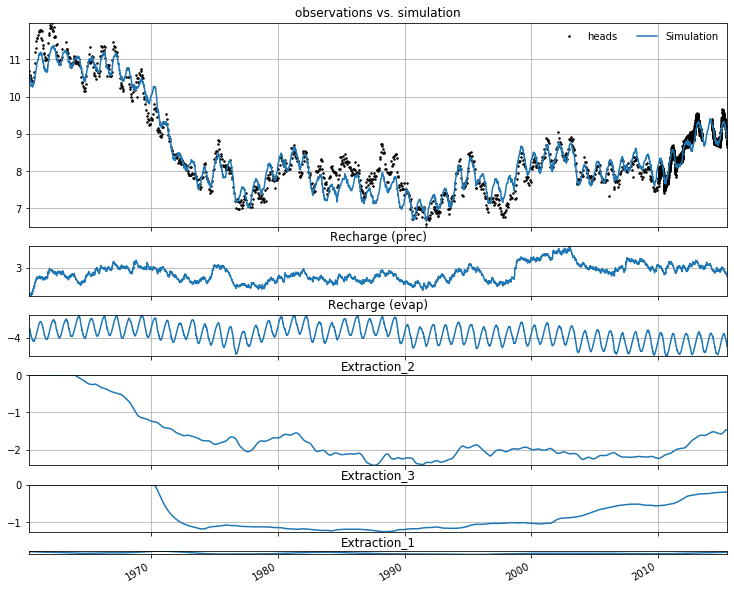

In [16]:
ml.plots.decomposition();

Plot the stacked influence of each of the individual extraction wells in the results plot

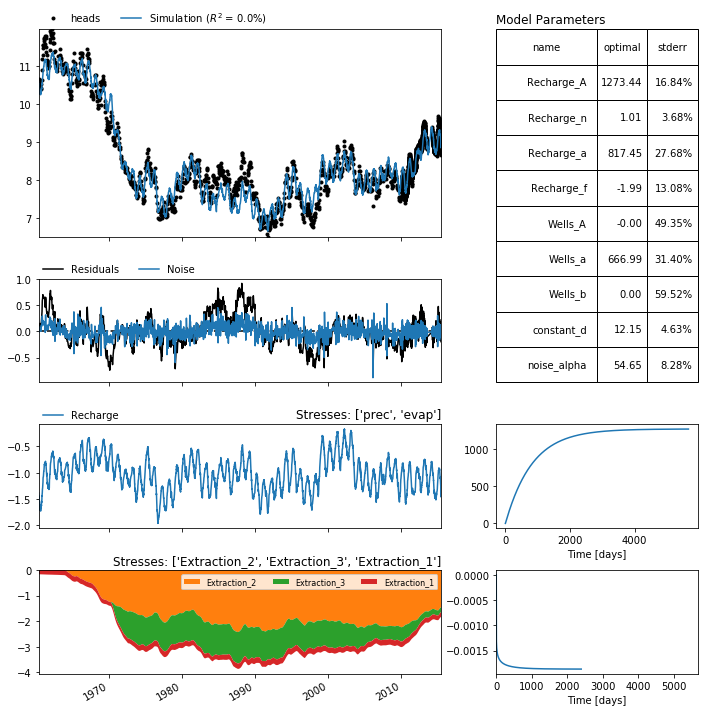

In [17]:
ml.plots.stacked_results(figsize=(10, 10));

Get parameters for each well (including the distance) and calculate the gain. The WellModel reorders the stresses from close to the observation well, to far from the observation well. We have take this into account during the post-processing.

The gain of extraction 1 is lower than the gain of extraction 2 and 3. This will always be the case in a WellModel when the distance from the observation well to extraction 1 is larger than the distance to extraction 2 and 3.

In [18]:
wm = ml.stressmodels["Wells"]
for i in range(3):
    p = wm.get_parameters(model=ml, istress=i)
    gain = wm.rfunc.gain(p) * 1e6 / 365.25
    name = wm.stress[i].name
    print("{0}: gain = {1:.2f} m / million m^3/year".format(name, gain))
    df.at[name, 'gain WellModel'] = gain

Extraction_2: gain = -0.23 m / million m^3/year
Extraction_3: gain = -0.17 m / million m^3/year
Extraction_1: gain = -0.04 m / million m^3/year


## Compare individual StressModels and WellModel

Compare the gains that were calculated by the individual StressModels and the WellModel.

In [19]:
df

,Distance to Observation well,gain StressModel,gain WellModel
Extraction_1,5076.464352,-0.037894,-0.041595
Extraction_2,2281.964490,-0.275095,-0.234769
Extraction_3,2783.783397,-0.128770,-0.168208
